# Pairs Trading

Leo Luo   - 2016.3

This is for building a pair trading strategy for any Pair of products.

The strategy enters or maintains a position if the size of difference between the N-day return on X and Y is greater than g, and flattens (exits) the position if the size of the difference is less than j (where j < g).

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import Quandl
import functools
import seaborn as sns
import ggplot as gg

# Read and clean data

In [3]:
#save data to cache
@functools.lru_cache(maxsize=16)
def fetch_quandl(my_securities):
    qdata = Quandl.get(list(my_securities), returns="pandas", authtoken="TzTcmaHpPQtRD3s_g2Z3")
    return qdata
raw_data = fetch_quandl(('EOD/PBE', 'EOD/XBI'))
raw_data = raw_data['2013-12-02':'2015-12-31'];

#clean and make data look nicer
def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('.')
        replacement_columns[c] = asset+":"+variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data
renamed_data = clean_quandl_columns(raw_data)
#renamed_data.tail()


In [4]:
pd.options.mode.chained_assignment = None    #mute the warning
df2 = renamed_data[["PBE:Adj_Volume","PBE:Adj_Close","XBI:Adj_Volume","XBI:Adj_Close"]]
df2.columns = ["A:Adj_Volume", "A:Adj_Close", "B:Adj_Volume", "B:Adj_Close"]
df2.ix[:,'Nt'] = np.nan

In [5]:
#Get the 15-day median of rolling volume as required
DollarVolume = df2['A:Adj_Close']  * df2['A:Adj_Volume']
N = 15
Ntdata = DollarVolume.rolling(center=False,window =N).median()
#df2.ix[N-1:,'Nt'] = Ntdata
df2['month'] = df2.index.month

#Derive a column that indicate end of month
df2['endofmonth'] = df2.month-df2.month.shift(-1)
df2.ix[-1,'endofmonth']=0
df2['endofmonth'][abs(df2['endofmonth'])>0] =1

In [6]:
# briefly see the data
df2.head()

,A:Adj_Volume,A:Adj_Close,B:Adj_Volume,B:Adj_Close,Nt,month,endofmonth
Date,,,,,,,
2013-12-02,48800.0,37.144366,2586600.0,42.889812,NaN,12,0.0
2013-12-03,62400.0,36.593788,1720200.0,42.360147,NaN,12,0.0
2013-12-04,56300.0,36.363725,714900.0,42.343799,NaN,12,0.0
2013-12-05,32000.0,36.220181,321600.0,41.820673,NaN,12,0.0
2013-12-06,47100.0,36.446312,388200.0,41.908950,NaN,12,0.0


# Build the Strategy

In [7]:
# building the stragety:
# M: M day avg return
# g: enter if abs(A - B) greater than g
# f: quit if abs(A - B) smaller than f
# s: stoploss if current cumulative ret <  - K*s

def run_strat(df2, M, g, j, s):
    #or we could use simple
    #df2['A_Mret'] = df2['A:Adj_Close'].pct_change(periods = M-1)
    #df2['B_Mret'] = df2['B:Adj_Close'].pct_change(periods = M-1)
    tb = df2
    tb['A_Mret'] = tb['A:Adj_Close'].rolling(M).apply(lambda x: np.log(x[-1]/x[0]))
    tb['B_Mret'] = tb['B:Adj_Close'].rolling(M).apply(lambda x: np.log(x[-1]/x[0]))
    tb['Diff_Mret'] = tb['A_Mret'] - tb['B_Mret'] #diff or Mret
    tb['Stoplose'] =0 #stoploss indicator
    tradingday = max(M, 15)
    
    preidx = tb.index[tradingday-1]
    testdata = tb[tradingday:];
    entry_gtc = 0 #entry gross traded capital
    A_Pos_i = 0 # Position of stock A in time i
    B_Pos_i = 0
    daypnl =[]
    cur_ret = 0
    for i, eom in zip(testdata.index, testdata.endofmonth):
        dollar_size = tb.ix[i, 'Nt'] / 100 #* tb.ix[i, 'A:Adj_Close']
        dayret = (tb.ix[i, 'A:Adj_Close'] - tb.ix[preidx, 'A:Adj_Close']) * A_Pos_i  + \
                (tb.ix[i, 'B:Adj_Close'] - tb.ix[preidx, 'B:Adj_Close']) * B_Pos_i
        daypnl.append(dayret)
        cur_ret += dayret
        #if end of month, close position
        if(abs(eom)> 0.1):
            A_Pos_i = 0
            B_Pos_i = 0
            entry_gtc = 0
            cur_ret = 0
        #if satisfy stoploss, then stoploss
        elif(abs(entry_gtc)>1 and cur_ret/entry_gtc <  -s):
            A_Pos_i = 0
            B_Pos_i = 0
            entry_gtc = 0
            cur_ret = 0
        #if satisfy buy or sell, then get position
        elif(abs(A_Pos_i)<1 and(abs(tb.ix[i, 'Diff_Mret']) > g)):
            A_Pos_i = - np.sign(abs(tb.ix[i, 'Diff_Mret']))* int(round(dollar_size / tb.ix[i, 'A:Adj_Close'])) 
            B_Pos_i = + np.sign(abs(tb.ix[i, 'Diff_Mret']))* int(round(dollar_size / tb.ix[i, 'B:Adj_Close'])) 
            entry_gtc = abs(A_Pos_i * tb.ix[i, 'A:Adj_Close']) + \
                abs(B_Pos_i * tb.ix[i, 'B:Adj_Close'])
        #if satisfy close position, then close
        elif (abs(tb.ix[i, 'Diff_Mret'])) < j or ((tb.ix[i, 'Diff_Mret']* tb.ix[preidx, 'Diff_Mret']) < 0):
            A_Pos_i = 0
            B_Pos_i = 0
            entry_gtc = 0
            cur_ret = 0
        preidx = i
    pnl = np.cumsum(daypnl)
    pnl_final = sum(daypnl)
    return (pnl, pnl_final)

In [8]:
#Run one strat and test running time
M, g, j, s = [10, 0.03, 0.005, 0.01]
from time import time
t1 = time()
(pnl, pnl_final) = run_strat(df2, M, g, j, s)
t2 = time()
print (t2-t1)   


0.1094050407409668


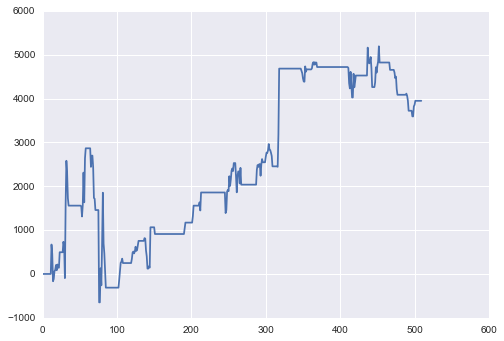

In [9]:
#see the P&L for one strategy
plt.plot(pnl)

# Analyze the the effect of different parameter

Since the stop loss is seldom used, first we keep s stable and change g,f and see what will happen

In [10]:
# draw heat-map for illustration
def drawMap(df2, M,g,j,s,ax):
    column_names = ['M','g','j','s','pnl'];
    result = pd.DataFrame(columns=column_names)
    for i in range(0, len(g)):
        for k in range(0, len(j)):
            (pnl, pnl_final) = run_strat(df2, M, g[i], j[k], s)
            #result[j][k] = pnl_final
            a = pd.DataFrame([[M, g[i], j[k], s,pnl_final]],columns=column_names )
            result = result.append(a ,ignore_index=True)
    rs = result.pivot("g","j","pnl")
    sns.heatmap(rs, ax=ax)
    ax.set_title('M = '+str(M))
    return


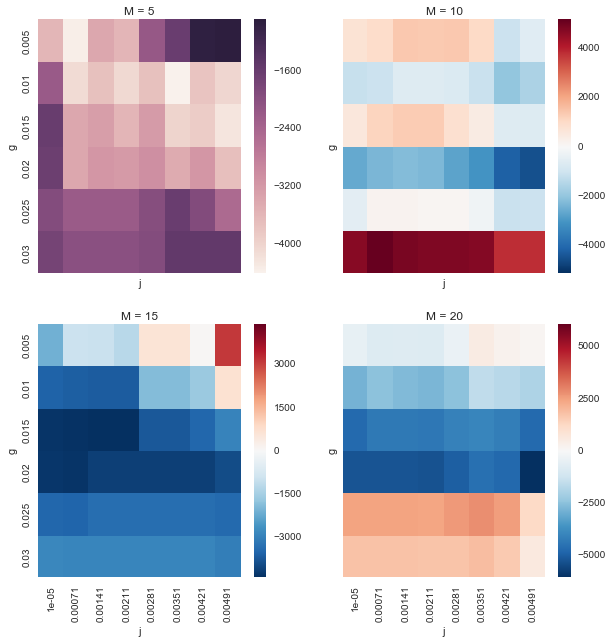

In [11]:
M=[5,10,15,20]
g = np.linspace(0.005,0.03,num=6)
j = np.linspace(0.00001,0.00491, num = 8)
s = 0.01
#result = np.zeros((len(g),len(f))) 
fig,axn = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,10))
for i, ax in enumerate(axn.flat):
    drawMap(df2, M[i],g,j,s,ax)


From the chart, we would see that we need to firstly pick a good M, and then as g is in the range, the higher the better.
For j (take profit), there is not trend for it.

# Find the global max with fix M

In [14]:
# find the global max with fix M
# actually this type of function does not work good for optimization 
from scipy.optimize import fmin
M = 10
def f(t): 
    g,j,s = t
    (pnl, pnl_final) = run_strat(df2, M, g, j, s)
    return -pnl_final
fmin(f,np.array([ 0.03,0.01,0.01]))


Optimization terminated successfully.
         Current function value: -4392.915137
         Iterations: 15
         Function evaluations: 45


array([ 0.02943056,  0.01068056,  0.00974537])

Actually using optimize here is not very applicable. Changing parameter will affect the result a lot. We'd better run a brute force search to find the maximum

# Alternative way to write algorithm, with detailed output

Here is a slow strategy, but we can see everyday Position of two securities, daily pnl, and how strategy is decided everyday


In [15]:

def run_strat_with_table(df2, M, g, f, s):
    tb = df2
    tb['A_Pos'] = 0
    tb['B_Pos'] = 0
    tb['dayret'] = 0
    tb['A_Mret'] = tb['A:Adj_Close'].rolling(M).apply(lambda x: np.log(x[-1]/x[0]))
    tb['B_Mret'] = tb['B:Adj_Close'].rolling(M).apply(lambda x: np.log(x[-1]/x[0]))
    tb['Stoplose'] =0 #stoploss indicator
    tb['Diff_Mret'] = tb['A_Mret'] - tb['B_Mret'] #diff or Mret
    preidx = tb.index[29]
    testdata = tb[30:]
    entry_gtc, entry_A, entry_B = [0,0,0]
    daypnl =[]
    for i, eom in zip(testdata.index, testdata.endofmonth):
        cur_pos_pnl = (tb.ix[i, 'A:Adj_Close'] - entry_A) * tb.ix[preidx, 'A_Pos'] + \
                (tb.ix[i, 'B:Adj_Close'] - entry_B) * tb.ix[preidx, 'B_Pos']
        dollar_size = tb.ix[i, 'Nt'] / 100 #* tb.ix[i, 'A:Adj_Close']
        dayret = (tb.ix[i, 'A:Adj_Close'] - tb.ix[preidx, 'A:Adj_Close']) * tb.ix[preidx, 'A_Pos']  + \
                (tb.ix[i, 'B:Adj_Close'] - tb.ix[preidx, 'B:Adj_Close']) * tb.ix[preidx, 'B_Pos']
        daypnl.append(dayret)
        tb.ix[i,'dayret'] = dayret
        if(abs(eom)> 0.1):
            tb.ix[i, 'A_Pos'] = 0
            tb.ix[i, 'B_Pos'] = 0
            entry_gtc = 0
        elif( cur_pos_pnl/entry_gtc) <  -s:
            tb.ix[i, 'A_Pos']=0; tb.ix[i, 'B_Pos']=0; entry_gtc =0;
            tb.loc[i,'Stoplose'] =1
        elif(tb.ix[preidx, 'A_Pos']>-1 and(tb.ix[i, 'Diff_Mret'] > g)):
            tb.ix[i, 'A_Pos'] = - int(round(dollar_size / tb.ix[i, 'A:Adj_Close'])) 
            tb.ix[i, 'B_Pos'] = + int(round(dollar_size / tb.ix[i, 'B:Adj_Close'])) 
            entry_A = tb.ix[i, 'A:Adj_Close'];
            entry_B = tb.ix[i, 'B:Adj_Close'];
            entry_gtc = abs(tb.ix[i, 'A_Pos'] * entry_B) + abs(tb.ix[i, 'B_Pos'] * entry_B)
        elif(tb.ix[preidx, 'A_Pos']<1 and (-tb.ix[i, 'Diff_Mret'] > g)):
            tb.ix[i, 'A_Pos'] = + int(round(dollar_size / tb.ix[i, 'A:Adj_Close'] ))
            tb.ix[i, 'B_Pos'] = - int(round(dollar_size / tb.ix[i, 'B:Adj_Close'] )) 
            entry_A = tb.ix[i, 'A:Adj_Close'];
            entry_B = tb.ix[i, 'B:Adj_Close'];
            entry_gtc = abs(tb.ix[i, 'A_Pos'] * tb.ix[i, 'A:Adj_Close']) + \
                abs(tb.ix[i, 'B_Pos'] * tb.ix[i, 'B:Adj_Close'])  
        elif (abs(tb.ix[i, 'Diff_Mret'])) < f:
            tb.ix[i, 'A_Pos']=0; tb.ix[i, 'B_Pos']=0; entry_gtc =0;
        elif (tb.ix[i, 'Diff_Mret']* tb.ix[preidx, 'Diff_Mret']) < 0:
            tb.ix[i, 'A_Pos']=0; tb.ix[i, 'B_Pos']=0; entry_gtc =0;
        else:
            tb.ix[i, 'A_Pos']=tb.ix[preidx, 'A_Pos']
            tb.ix[i, 'B_Pos']=tb.ix[preidx, 'B_Pos']
        tb.ix[i, 'entry_gtc'] = entry_gtc
        preidx = i
    pnl = np.cumsum(daypnl)
    pnl_final = sum(daypnl)
    return (tb, pnl, pnl_final)


In [16]:
M, g, j, s = [10, 0.03, 0.005, 0.01]
from time import time
t1 = time()
(res, pnl, pnl_final) = run_strat_with_table(df2, M, g, j, s)
t2 = time()
t2-t1    

3.388011932373047

In [17]:
res.tail()

,A:Adj_Volume,A:Adj_Close,B:Adj_Volume,B:Adj_Close,Nt,month,endofmonth,A_Mret,B_Mret,Diff_Mret,Stoplose,A_Pos,B_Pos,dayret,entry_gtc
Date,,,,,,,,,,,,,,,
2015-12-24,4579.0,50.56,748447.0,70.797534,1.617117e+06,12,0.0,0.061726,0.077579,-0.015853,0,0,0,0.0,0.0
2015-12-28,20450.0,50.49,2537425.0,69.638884,1.463006e+06,12,0.0,0.063482,0.073016,-0.009534,0,0,0,-0.0,0.0
2015-12-29,42151.0,51.31,2112230.0,71.456766,1.617117e+06,12,0.0,0.051468,0.070550,-0.019082,0,0,0,0.0,0.0
2015-12-30,21864.0,50.99,1469633.0,70.777557,1.463006e+06,12,0.0,0.017460,0.018078,-0.000618,0,0,0,-0.0,0.0
2015-12-31,18465.0,50.52,1302527.0,70.118325,1.424342e+06,12,0.0,0.021778,0.019823,0.001955,0,0,0,-0.0,0.0
